We computed electronic couplings between the various states at QM level.
We can model the kinetics of the generation of the Charge Separated State with a set of coupled differential equations describing the population of each state.

\begin{align}
\dot{P}_{GS} & = k_{CR} \cdot P_{CT} \\
\dot{P}_{LE_D} & =  -(k_{EET} + k_{PET}) \cdot P_{LE_D} \\
\dot{P}_{LE_A} & = k_{EET} \cdot P_{LE_D} - k_{PHT} \cdot P_{LE_A} \\
\dot{P}_{CT} & = k_{PET} \cdot P_{LE_D} + k_{PHT} \cdot P_{LE_A} - k_{CR} \cdot P_{CT}
\end{align}

Gathering populations of state in a vector $\mathbf{P}$ we can write this set of coupled equations in matrix form, as in

\begin{equation}
\dot{\mathbf{P}}(t) = \mathbf{K} \mathbf{P}(t)
\end{equation}

where we have defined the matrix of rate constants $\mathbf{K}$ as in the following.

\begin{equation}
\mathbf{K} = \begin{pmatrix} 0 & 0 & 0 & k_{CR} \\ 0 & -(k_{EET} + k_{PET}) & 0 & 0 \\ 0 & k_{EET} & -k_{PHT} & 0 \\ 0 & k_{PET} & k_{PHT} & -k_{CR} \end{pmatrix}
\end{equation}

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint

df = pd.read_csv("rate_constants.csv")

mdls = df[["DonorName", "AccptName", "BindingEne / eV"]]
rates = df[["k_EET avg / Hz", "k_CR avg / Hz", "k_PHT avg / Hz", "k_PET avg / Hz"]]

In [2]:
# Define rate constants matrix
def make_K_matrix(*rates):
    
    K = np.zeros((4,4))
    K[0,-1] = rates[1] # k_CR 
    K[1,1] = -(rates[0] + rates[-1]) # -(k_EET + k_PET)
    K[2,1] = rates[0] # k_EET
    K[2,2] = -rates[2] # -k_PHT
    K[3,1] = rates[-1] # k_PET
    K[3,2] = rates[2] # k_PHT
    K[3,-1] = -rates[1] # -k_CR
    
    return K

# Define population derivatives in time
def dPdt(P, t, K):
    return np.dot(K, P)

# Define time window
t = np.arange(0, 10, 1e-2)

# Define initial conditions
P0 = np.zeros(4)

# Initial population in the Donor Local Excitation
P0[1] = 1

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, ticker, gridspec
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


# Define a function to plot solutions to the system of coupled ODEs for each
# model
def plot_pops(t, sol, mdl_name):
    
    fig = plt.figure(figsize=(12, 9))
    gs = gridspec.GridSpec(1, 1)

    ax = plt.subplot(gs[0])

    ax.plot(t, sol[:,0], lw=2, color="b", label="GS")
    ax.plot(t, sol[:,1], lw=2, color="g", label="LED")
    ax.plot(t, sol[:,2], lw=2, color="orange", label="LEA")
    ax.plot(t, sol[:,3], lw=2, color="r", label="CT")

    ax.set_xlabel(r"$t$ / ps", size=30, labelpad=5)
    ax.set_ylabel(r"$P$", size=30, labelpad=5)

    xtickmaj = ticker.MultipleLocator(10)
    xtickmin = ticker.AutoMinorLocator(5)
    ytickmaj = ticker.MultipleLocator(0.2)
    ytickmin = ticker.AutoMinorLocator(4)
    
    ax.set_xlim(0,10)
    xtickmaj = ticker.MultipleLocator(2)
    xtickmin = ticker.AutoMinorLocator(4)
    ytickmaj = ticker.MultipleLocator(0.2)
    ytickmin = ticker.AutoMinorLocator(4)
    
    ax.xaxis.set_major_locator(xtickmaj)
    ax.xaxis.set_minor_locator(xtickmin)
    ax.yaxis.set_major_locator(ytickmaj)
    ax.yaxis.set_minor_locator(ytickmin)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='major', direction='in', labelsize=28, pad=10, length=5)
    ax.tick_params(axis='both', which='minor', direction='in', labelsize=28, pad=10, length=2)

    ax.legend(loc=1, fontsize=22, frameon=False)

    plt.title("%s/%s %s" % tuple(mdl_name.split("_")), size=32)
    # plt.savefig("%s.svg" % mdl_name.replace(" eV", ""), dpi=600)
    plt.show()
    
    return

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


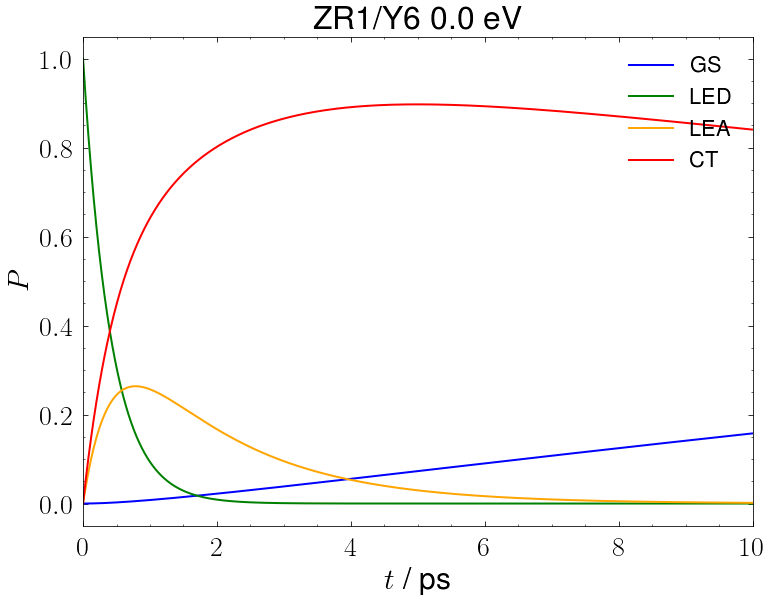

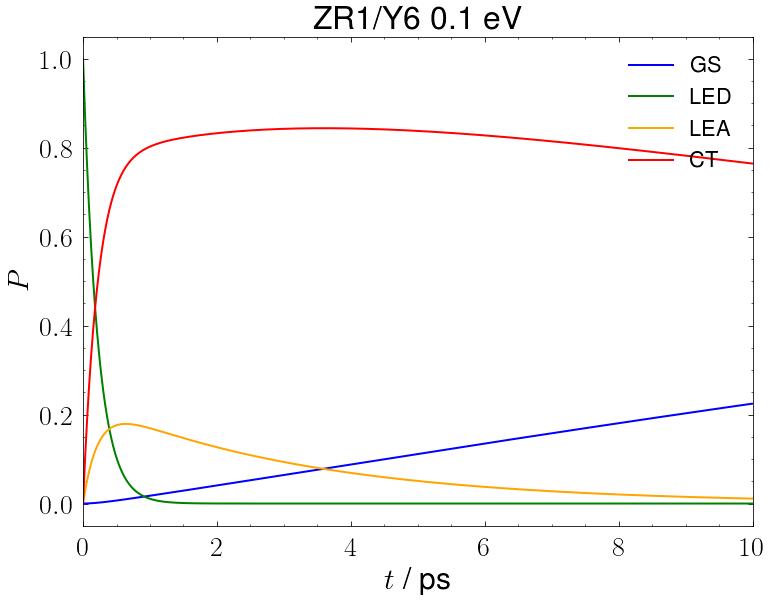

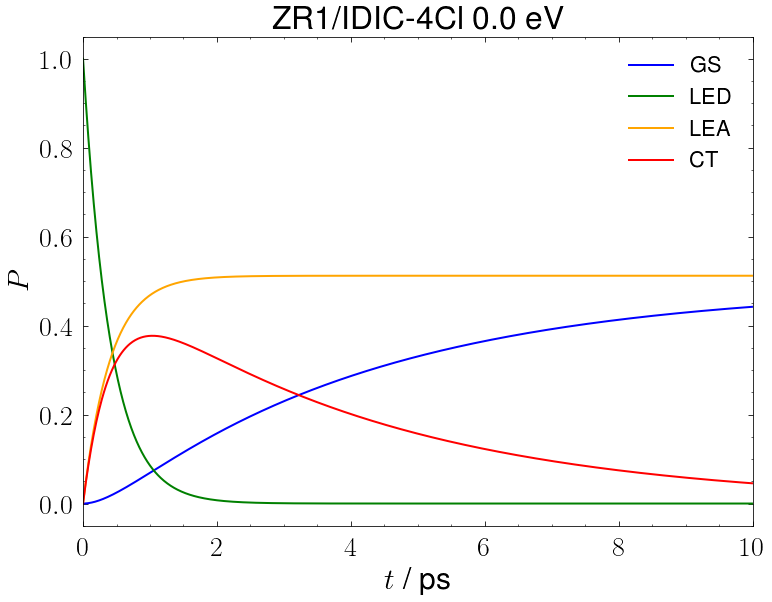

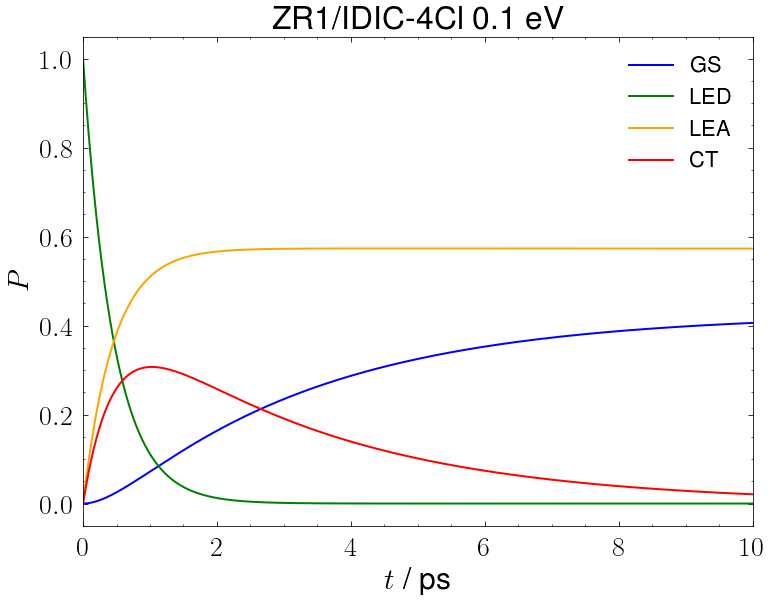

In [4]:
# Loop over models
for i, mdl in enumerate(mdls.values):
    
    # Define model name
    D, A, BE = mdl
    mdl_name = "%s_%s_%3.1f eV" % (D, A, BE)
    
    # Get avg rates
    ks = rates.values[i] * 1e-12
    
    # Define rate constants matrix
    K = make_K_matrix(*ks)
    
    # Numerically integrate the system of ODEs
    sol = odeint(dPdt, P0, t, args=(K,))
    
    # plot the solutions
    plot_pops(t, sol, mdl_name)